# Analysis of P300 data using Timeflux (mimic online)

In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
from timeflux.core.branch import Branch
import warnings 

warnings.filterwarnings('ignore') # Silents pandas warning of Timeflux Epoch


### Load the data from HDF5

In [2]:
store = pd.HDFStore("../data/timeflux-P300-HELLOWORLD.hdf5", "r")
events = store.select("events")
signal = store.select("eeg")

rate = 250


### Timeflux analysis: filter & epoch

In [3]:
graph = {
 'nodes': [
  {'id': 'notch',
   'module': 'timeflux_dsp.nodes.filters',
   'class': 'IIRLineFilter',
   'params': {'rate': rate,
    'edges_center': [50, 100],
    'orders': [2, 1],
    'edges_width': [3, 3]}},
  {'id': 'bandpass',
   'module': 'timeflux_dsp.nodes.filters',
   'class': 'IIRFilter',
   'params': {'rate': rate, 'order': 3, 'frequencies': [1, 40]}},
  {'id': 'epoch',
   'module': 'timeflux.nodes.epoch',
   'class': 'Epoch',
   'params': {'event_trigger': 'flash_begins', 'before': 0, 'after': 0.9}},
  {'id': 'trim',
   'module': 'timeflux.nodes.epoch',
   'class': 'Trim',
   'params': {'samples': 200}}
  ],
 'edges': [
  {'source': 'notch', 'target': 'bandpass'},
  {'source': 'bandpass', 'target': 'epoch'},
  {'source': 'epoch:*', 'target': 'trim'}
  ]}

In [4]:
app = Branch(graph)

app.set_port("notch", port_id="i", data=signal)
app.set_port("epoch", port_id="i_events", data=events)

app.update()


In [5]:
epochs = np.stack([port.data.values[:200, :] for (_, _, port) in app._scheduler._nodes["epoch"].iterate("o*")])
labels = np.array([port.meta["epoch"]["context"].get("includes_target") for (_, _, port) in app._scheduler._nodes["epoch"].iterate("o*")])

epochs_target = epochs[labels==True, : ]
epochs_nonTarget = epochs[labels==False, : ]


### Plot the ERP

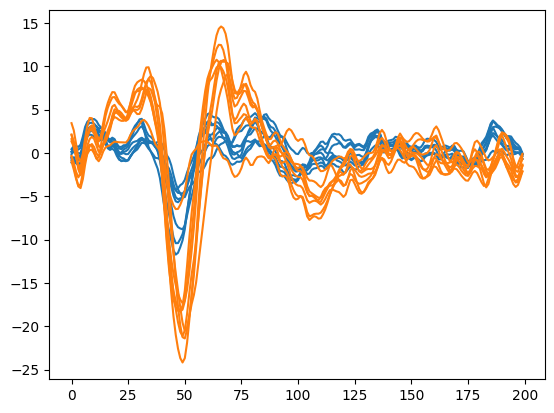

In [7]:
plt.figure()
plt.plot(np.mean(epochs_nonTarget, axis=0), color="C0");
plt.plot(np.mean(epochs_target, axis=0), color="C1");